In [2]:
%matplotlib inline
from IPython.display import Markdown, display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def printmd(data):
    display(Markdown(data))

In [4]:
# loop time
LOOP_TIME = 4000 / 1e6
LOOP_TIME

0.004

In [5]:
df_calibration = pd.read_csv('./calibration.csv')
df_calibration = df_calibration[500:-500]
# df_calibration = df_calibration.drop(['tmp'], axis=1)
df_calibration = df_calibration[['gx', 'gy', 'gz']]
df_calibration

,gx,gy,gz
500,-83,76,-10
501,-85,76,-14
502,-88,75,-16
503,-88,82,-13
504,-83,77,-17
...,...,...,...
3010,-85,79,-17
3011,-79,84,-20
3012,-82,84,-19
3013,-85,74,-15


In [6]:
avg = np.average(df_calibration.values, axis=0)
avg = np.reshape(avg, (1,-1))
df_calibration = pd.DataFrame(data=avg, columns=df_calibration.columns)
df_calibration

,gx,gy,gz
0,-84.405567,78.182505,-15.367396


In [7]:
df_data_raw = pd.read_csv('./data.csv')
df_data_raw = df_data_raw.drop(['tmp'], axis=1)
df_data_raw

,gx,gy,gz,ax,ay,az
0,-85,80,-14,-335,7,3964
1,-88,72,-16,-336,12,3970
2,-85,74,-10,-332,9,3973
3,-84,80,-13,-335,-4,3970
4,-82,76,-16,-336,1,3952
...,...,...,...,...,...,...
5280,-86,39,-16,-360,1,3947
5281,-93,45,-19,-359,4,3957
5282,-82,46,-17,-359,13,3945
5283,-85,53,-16,-356,7,3929


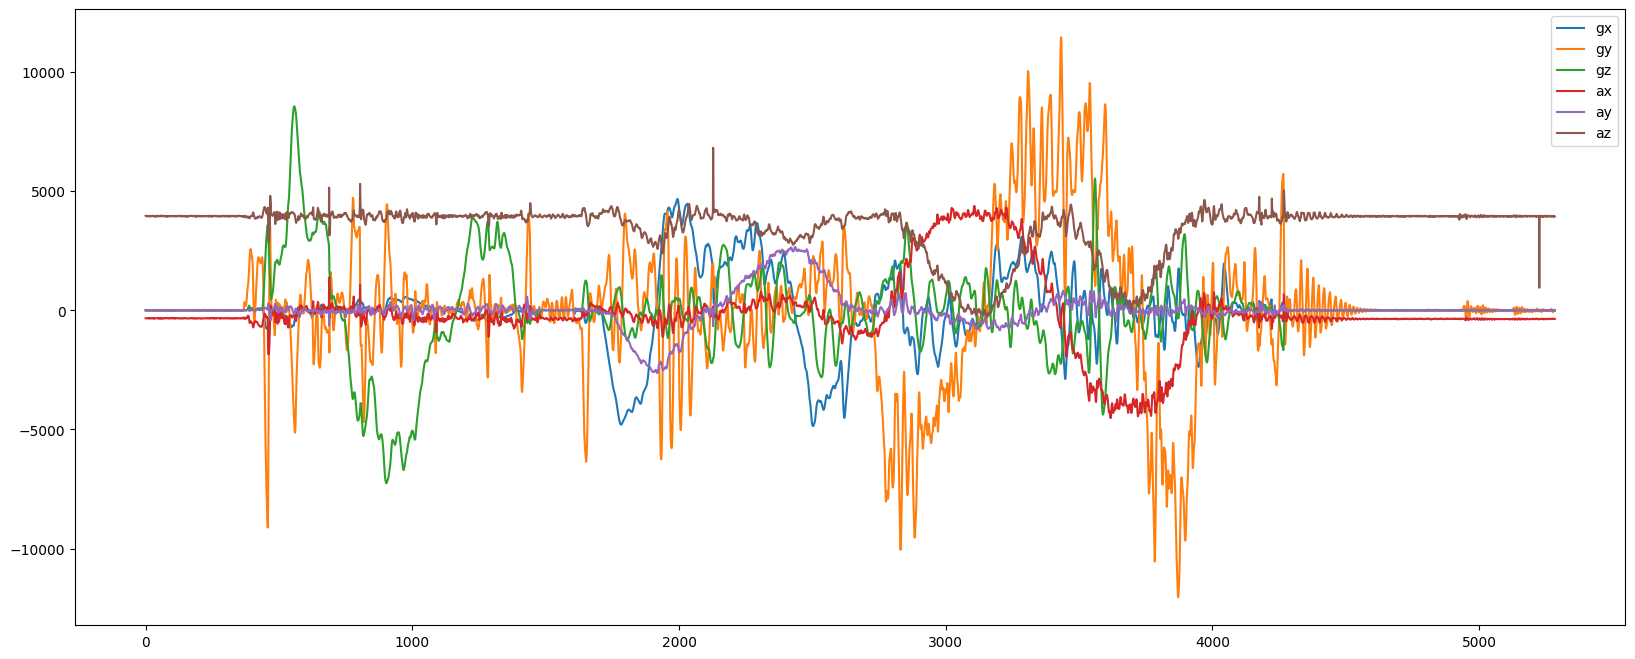

In [8]:
# calibration
data_raw = []
for i, row in df_data_raw.iterrows():
    data_raw.append([
        row['gx'] - df_calibration['gx'].values[0],
        row['gy'] - df_calibration['gy'].values[0],
        row['gz'] - df_calibration['gz'].values[0],
        row['ax'],
        row['ay'],
        row['az']
    ])

data_raw = np.array(data_raw)
df_data_raw = pd.DataFrame(data=data_raw, columns=df_data_raw.columns)

plt.figure(figsize=(20,8))
# plt.plot(df_data['a_z'])
plt.plot(df_data_raw)
plt.legend(df_data_raw.columns)
plt.show()

# Recreate control input from data

# Input commands

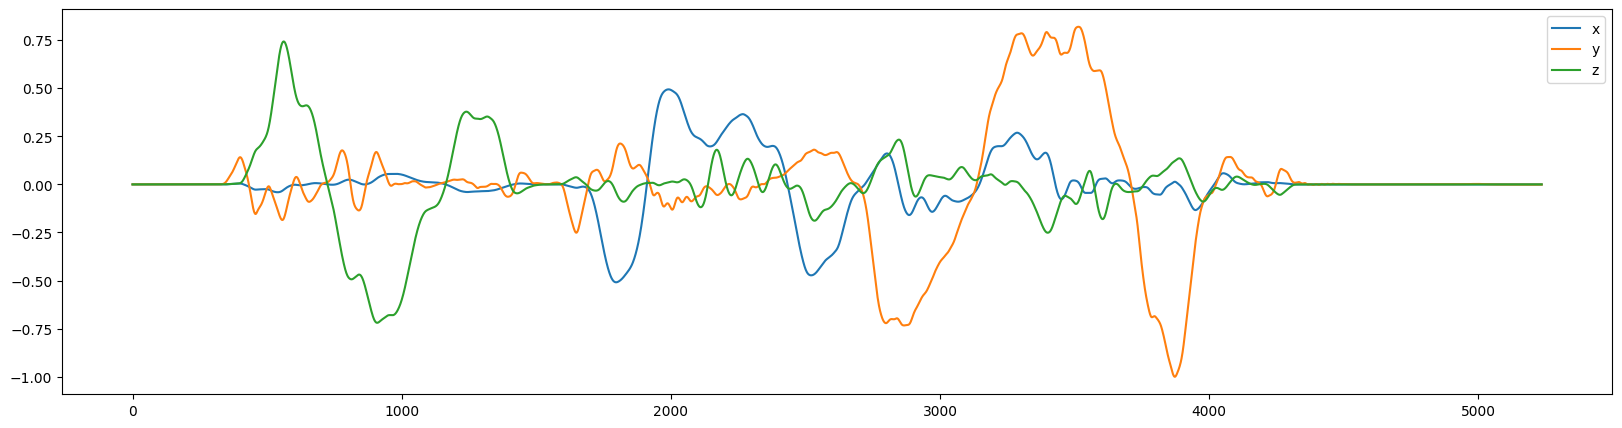

In [9]:
window_size = 50
input_commands = [
    df_data_raw['gx'].rolling(window=window_size).mean().rolling(window=window_size).mean()[(window_size - 1) * 1:].reset_index(drop=True).fillna(0).values,
    df_data_raw['gy'].rolling(window=window_size).mean().rolling(window=window_size).mean()[(window_size - 1) * 1:].reset_index(drop=True).fillna(0).values,
    df_data_raw['gz'].rolling(window=window_size).mean().rolling(window=window_size).mean()[(window_size - 1) * 1:].reset_index(drop=True).fillna(0).values
]
input_commands = np.array(input_commands)
input_commands = np.transpose(input_commands)
input_commands = pd.DataFrame(data=input_commands, columns=['x', 'y', 'z'])
# normalize data
input_commands = input_commands / np.max(np.abs(input_commands))

# make shape of data same as input
df_data_raw = df_data_raw[:input_commands.shape[0]]

printmd('# Input commands')
plt.figure(figsize=(20,5))
plt.plot(input_commands)
plt.legend(input_commands.columns)
plt.show()

# Implementing the Extended Kalman Filter (EKF)

In [41]:
class ExtendedKalmanFilter:
    def __init__(self):
        # State estimate (roll, pitch, yaw)
        self.x = np.array([[0], [0], [0]])
        # Error covariance matrix
        self.P = np.eye(3)
        # self.P = np.array([
        #     [1, 0, 0],
        #     [0, 1, 0],
        #     [0, 0, 0]
        # ])
        # Process noise covariance
        # self.Q = np.diag([0.01, 0.01, 0.01])
        self.Q = np.diag([0.01, 0.01, 0.00])
        # Measurement noise covariance
        self.R = np.diag([0.1, 0.1, 0.1])
        # previous prev_accel_data
        self.prev_accel_data = np.array([[0], [0], [0]])
        self.alpha = 0.02
    

    def predict(self, gyro_data, dt):
        # Predict state using gyro data
        self.x = self.x + gyro_data * dt
        # Update error covariance
        self.P = self.P + self.Q
        return self.x

    def update(self, accel_data):
        accel_data = accel_data * self.alpha + (1 - self.alpha) * self.prev_accel_data
        self.prev_accel_data = accel_data
        # Compute measurement residual
        residual = accel_data - self.x
        # Compute Kalman gain
        K = self.P.dot(np.linalg.inv(self.P + self.R))
        # K[2][2] = 0
        # print(K)
        # Update state estimate
        self.x = self.x + K.dot(residual)
        # Update error covariance
        self.P = (np.eye(3) - K).dot(self.P)
        return self.x

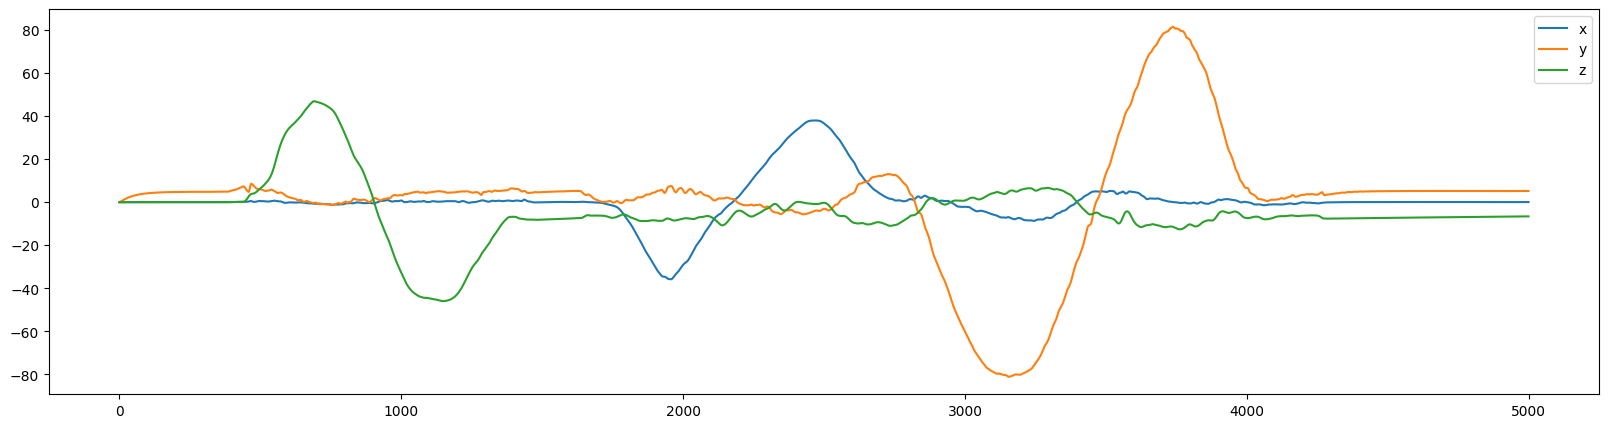

In [42]:
# Example usage:
ekf = ExtendedKalmanFilter()

ekf_states = []

for row in df_data_raw.values[:5000]:
    gyro_data = row[:3] / 65.5 #* LOOP_TIME
    gyro_data = gyro_data.reshape(-1,1)
    
    # Predict using gyro data
    predicted_state = ekf.predict(gyro_data, LOOP_TIME)

    # print(predicted_state.flatten())

    accel_data = row[3:]
    accel_data = np.rad2deg(np.array([
        np.arctan(accel_data[1] / np.sqrt(accel_data[0]**2 + accel_data[2]**2)),
        np.arctan(-accel_data[0] / np.sqrt(accel_data[1]**2 + accel_data[2]**2)),
        0 #np.arccos(accel_data[2] / np.sqrt(np.sum(accel_data ** 2)))
    ]))

    accel_data = accel_data.reshape(-1, 1)
    # Update using accelerometer data
    updated_state = ekf.update(accel_data)
    ekf_states.append(updated_state.reshape(3))

    # print(updated_state.flatten())

    # print('\n\n')

ekf_states = np.array(ekf_states)

plt.figure(figsize=(20,5))
plt.plot(ekf_states)
plt.legend(['x', 'y', 'z'])
plt.show()

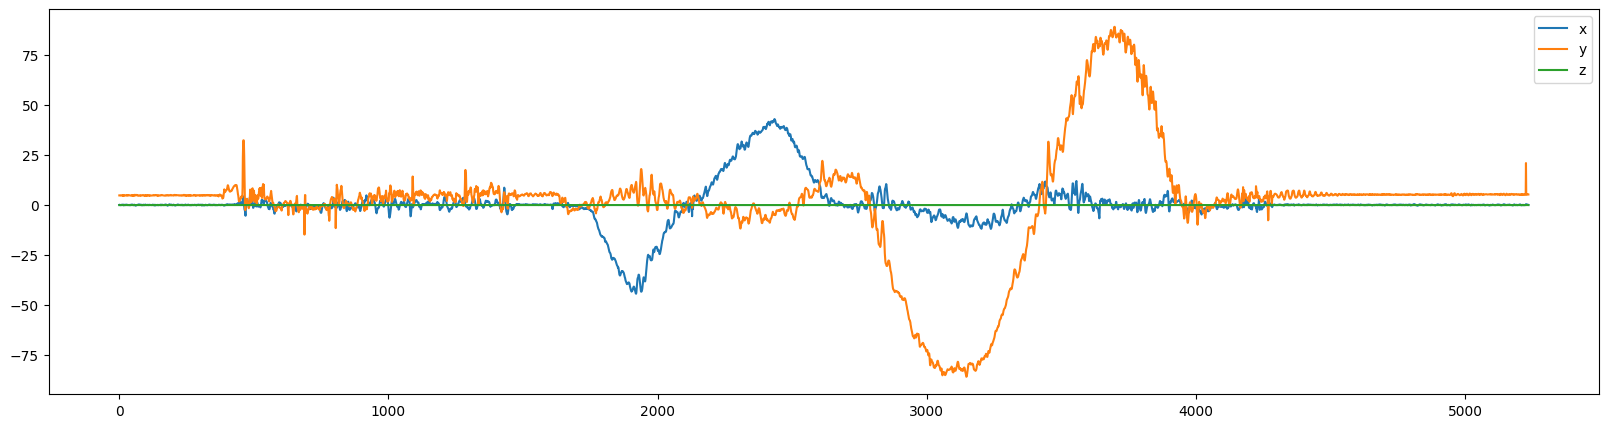

In [12]:
accel_angle = []
for row in df_data_raw.values:
    accel_data = row[3:]
    # accel_angle.append(np.rad2deg(np.array([
    #     np.arcsin(accel_data[1] / np.sqrt(np.sum(accel_data ** 2))),
    #     -np.arcsin(accel_data[0] / np.sqrt(np.sum(accel_data ** 2))),
    #     0 #np.arccos(accel_data[2] / np.sqrt(np.sum(accel_data ** 2)))
    # ])))

    accel_angle.append(np.rad2deg(np.array([
        np.arctan(accel_data[1] / np.sqrt(accel_data[0]**2 + accel_data[2]**2)),
        np.arctan(-accel_data[0] / np.sqrt(accel_data[1]**2 + accel_data[2]**2)),
        0 #np.arccos(accel_data[2] / np.sqrt(np.sum(accel_data ** 2)))
    ])))

accel_angle = np.array(accel_angle)

plt.figure(figsize=(20,5))
plt.plot(accel_angle)
plt.legend(['x', 'y', 'z'])
plt.show()

In [24]:
np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 0]])